In [128]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import copy
import yfinance as yf
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [129]:
"""Testing for a GPU"""

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))
x = tf.random.uniform([3, 3])

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[]
Is the Tensor on GPU #0:  
False


Data Preperation

In [130]:
"""Loading s&p 100 tickers"""



sample_tickers = ['AAPL'] #, 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
interval = '1h'
training_start = "2024-03-03"
training_end = "2025-10-10"
testing_end = "2026-01-01"
data = yf.download(sample_tickers, start=training_start, end=training_end, interval=interval)

close = data['Close']
volume = data['Volume']


[*********************100%***********************]  1 of 1 completed


In [131]:
close.head()

Ticker,AAPL
Datetime,
2024-03-04 14:30:00+00:00,174.169998
2024-03-04 15:30:00+00:00,174.815002
2024-03-04 16:30:00+00:00,174.626999
2024-03-04 17:30:00+00:00,173.904999
2024-03-04 18:30:00+00:00,174.350006


In [132]:
close.tail()

Ticker,AAPL
Datetime,
2025-10-09 15:30:00+00:00,253.845001
2025-10-09 16:30:00+00:00,253.457596
2025-10-09 17:30:00+00:00,253.559998
2025-10-09 18:30:00+00:00,253.899994
2025-10-09 19:30:00+00:00,253.979996


In [133]:
close_np = data['Close'].to_numpy()
volume_np = data['Volume'].to_numpy()

In [134]:
from technical_indicators import AddTechnicalIndicators

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()




/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()


In [135]:
print(data[0])

[174.16999817          nan 174.16999817          nan]


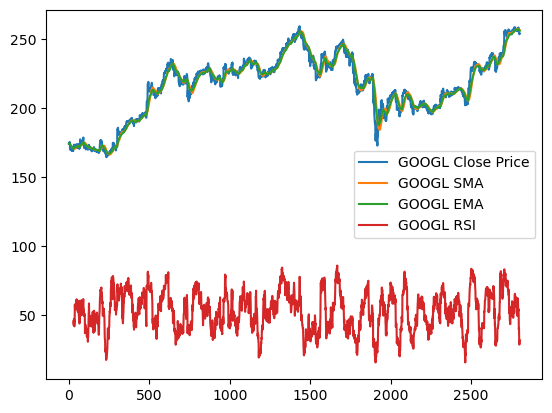

In [136]:
googl = data[:, 0]
googl_sma = data[:, 1]
googl_ema = data[:, 2]
googl_rsi = data[:, 3]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [137]:
print(data.shape)

(2805, 4)


In [138]:
from numpy.lib.stride_tricks import sliding_window_view

def add_look_back(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i])
    return numpy.array(X), numpy.array(y)

In [139]:
lookback = 10
x, y = add_look_back(data, look_back=lookback)
print(x.shape)
print(y.shape)
print(close.shape)


(2795, 10, 4)
(2795, 4)
(2805, 4)


In [140]:
print(data_frame.to_numpy())
print(data_frame.to_numpy().shape)

[[174.16999817          nan 174.16999817          nan]
 [174.81500244          nan 174.21161135          nan]
 [174.6269989           nan 174.23841054          nan]
 ...
 [253.55999756 256.72620646 256.23572476  29.00958417]
 [253.8999939  256.57920634 256.08503245  31.6013557 ]
 [253.97999573 256.43287303 255.94922363  31.71533417]]
(2805, 4)


In [141]:

a = np.array([ [0, 10, 20, 30], [2, 9, 19, 40],[3, 8, 19, 21] ])

assert np.array_equal(np.min(a, axis=0), np.array([0, 8, 19, 21])), f'not equal {np.min(a)},  {np.array([0, 9, 19, 30])}'

class MinMaxScaling:
    def __init__(self, data):

        self.min =np.max(np.array([np.min(data, axis=0), np.ones(data.shape[1])/100_0000 ]),axis=0)
        self.max = np.max(data, axis = 0)
        print(self.min,self.max)
    def transform(self, x):

        return (x - self.min)/(self.max - self.min)
    
    def inverse(self, x):
        return x*(self.max - self.min) + self.min

class RollingZScoreNorm:
    def __init__(self, data, look_back=30):
        self.data = data
    
    
    def get_rolling_z(self, window=30):
        """Add Rolling Z-Score to the data."""
        """Final Ouput must then me computed as """

        data = self.data
        data_np = data.to_numpy()
        normalized_data = copy.deepcopy(data)

        for col in self.data.columns:
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            normalized_data[col] = (data[col] - rolling_mean) / rolling_std

        # Starts at 
        
        normalized_data = []

        print(data_np.shape)
        print(window)

        for col in range(data_np.shape[1]):
            print(col)
            column = []
            print(window, data_np.shape[0])
            for i in range(window, data_np.shape[0]):
                print(i)
                data_window = data_np[i - window:i][col]
                print(i-window, i, col, data_window)
                mean = np.mean(data_window)
                variance = np.var(data_window)
                column.append((data_window[-1]-mean )/ variance)

                assert False

            normalized_data.append(column)

        assert np.array(normalized_data).shape[1:] == data_np.shape[1:], f'Mishmach normed:{np.array(normalized_data).shape[1:]}  data:{data_np.shape[1:]} full shapes: normed:{np.array(normalized_data).shape}  data:{data_np.shape} '

                
        
        return np.array(normalized_data)
    
    def inverse_transform(self, normalized_output, window=30):
        """normalized_output must be a numpy array"""
        """Inverse transform the normalized data back to original scale."""
        data = self.data
        inv_data = normalized_output.copy()


        for i, col in  enumerate(self.data.columns):
            rolling_mean = data[col].rolling(window=window).mean()
            rolling_std = data[col].rolling(window=window).std()
            inv_data[i] = (normalized_output[i] * rolling_std) + rolling_mean
        return inv_data
    


In [142]:
data = data_frame.to_numpy()[59:]

In [143]:
# norm_class = RollingZScoreNorm(data_frame)
# norm_data = norm_class.get_rolling_z(wi)
print(data.shape)
min_max_scaling = MinMaxScaling(data)
norm_data = min_max_scaling.transform(data)


(2746, 4)
[164.36239624 166.3294693  166.90356716  15.67504946] [259.10998535 257.35357819 257.08455351  85.89076231]


In [144]:
# norm_data.to_numpy()[29]

In [145]:

x, y = add_look_back(norm_data, look_back=lookback)

X = x
Y = y[:, :5]

In [146]:
print(X.shape, Y.shape)

(2736, 10, 4) (2736, 4)


Basic Model

In [147]:
from keras import layers, Sequential

In [148]:
print(lookback, X.shape[2])

10 4


In [149]:
model = keras.Sequential()

model.add(layers.Dense(512, input_shape=(lookback, X.shape[-1])))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(256))
model.add(layers.Dropout(0.1))

model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(128)) 
model.add(layers.Dropout(0.1))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(Y.shape[-1], activation='linear'))


model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/mb0w3n/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/mb0w3n/anaconda3/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [150]:
model.fit(X,Y, epochs=10, batch_size=32)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0197 - mae: 0.0956
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0052 - mae: 0.0552
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0041 - mae: 0.0477
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0035 - mae: 0.0444
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0031 - mae: 0.0419
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0028 - mae: 0.0396
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0027 - mae: 0.0386
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0024 - mae: 0.0368
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0024 - mae: 0.0366
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0023 - mae: 0.0357


Test and Visuals

In [151]:
preds = model.predict(X)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [152]:
print(preds.shape, Y.shape, X.shape)

(2736, 4) (2736, 4) (2736, 10, 4)


In [153]:
def directional_accuracy(predictions, actuals):
    """
    Evaluate the directional accuracy of predictions against actual values.
    
    This metric calculates the percentage of predictions that correctly 
    identify the direction (positive/negative) of the actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values
        actuals (numpy.ndarray): Actual/true values
    
    Returns:
        float: Directional accuracy as a percentage (0-100)
    """
    if predictions.shape != actuals.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs actuals {actuals.shape}")
    
    # Check if both predictions and actuals have the same direction
    # (both > 0, both < 0, or both == 0)
    correct_direction = ((actuals > 0) == (predictions > 0)).mean()
    
    return correct_direction * 100  # Return as percentage



In [154]:
def mae(predictions, actuals):

    return np.abs(predictions - actuals).mean()

In [155]:
def plot_predictions_by_asset(predictions, actuals, tickers):
    """
    Generate individual plots for each asset showing predicted vs actual values.
    
    Args:
        predictions (numpy.ndarray): Predicted values with shape (samples, num_assets)
        actuals (numpy.ndarray): Actual values with shape (samples, num_assets)
        tickers (list): List of ticker symbols corresponding to each asset
    """
    num_assets = len(tickers)
    fig, axes = plt.subplots(num_assets, 1, figsize=(12, 3*num_assets))

    if num_assets == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        axes[i].plot(actuals[:, i], label='Actual', linewidth=2, alpha=0.8)
        axes[i].plot(predictions[:, i], label='Predicted', linewidth=2, alpha=0.8)
        axes[i].set_title(f'{ticker} - Predicted vs Actual Values : acc = {directional_accuracy(predictions[:, i], actuals[:, i])}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Normalized Price')
        axes[i].legend(loc='upper left')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [156]:
print(directional_accuracy(preds, Y))
print(mae(preds, Y))

99.92690058479532
0.026738172145436247


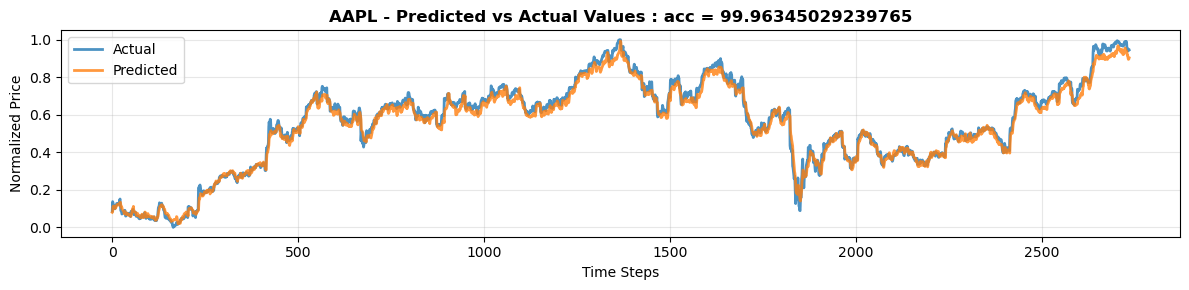

In [157]:
plot_predictions_by_asset(preds, Y, sample_tickers)

Testing And Validation

[*********************100%***********************]  1 of 1 completed
/home/mb0w3n/project/IndividualProject/technical_indicators.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name, 'SMA'] = data[name].rolling(window=window).mean()


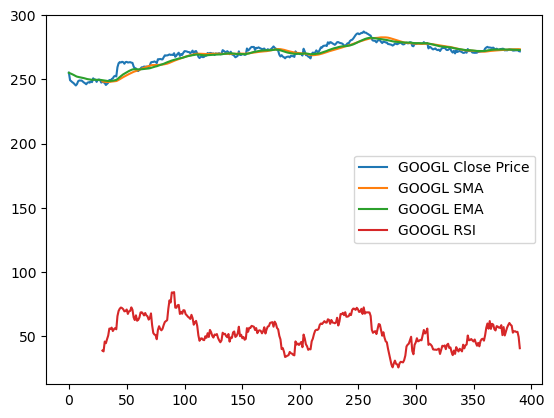

In [158]:
data = yf.download(sample_tickers, start=training_end, end=testing_end, interval = interval)
close = data['Close']

indicator_class = AddTechnicalIndicators(close, sample_tickers)
data = indicator_class.add_sma()
data = indicator_class.add_ema()
data = indicator_class.add_rsi()

data_frame = data 
data = data.to_numpy()

googl = data[:, 0]
googl_sma = data[:, 1]
googl_ema = data[:, 2]
googl_rsi = data[:, 3]

plt.plot(googl, label='GOOGL Close Price')
plt.plot(googl_sma, label='GOOGL SMA')
plt.plot(googl_ema, label='GOOGL EMA')
plt.plot(googl_rsi, label='GOOGL RSI')
plt.legend()
plt.show()

In [159]:

# norm_class = RollingZScoreNorm(data_frame)
# norm_data = norm_class.get_rolling_z(window=lookback)
data_frame = data_frame.to_numpy()[59:]


norm_data = min_max_scaling.transform(data_frame)

test_x, test_y = add_look_back(norm_data, look_back=lookback)

test_y = test_y[:, 0].reshape(test_y.shape[0], 1)

print(test_y.shape, test_x.shape)

(322, 1) (322, 10, 4)


In [160]:
test_pred = model.predict(test_x)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [161]:
print(test_pred.shape)

(322, 4)


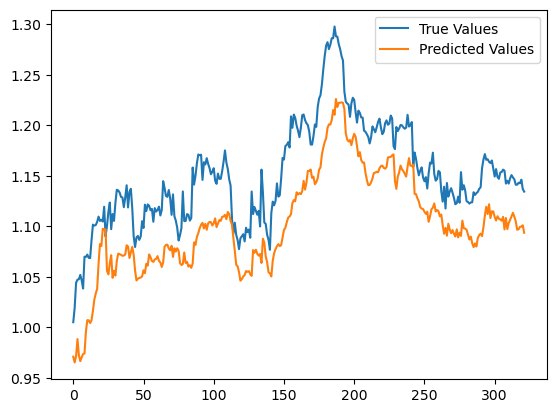

In [162]:
plt.plot(test_y[:, 0], label='True Values')
plt.plot(test_pred[:, 0], label='Predicted Values')
plt.legend()

In [163]:
test_pred = test_pred[:,0].reshape(test_y.shape)
print(directional_accuracy(test_pred, test_y))
print(mae(test_pred, test_y))

100.0
0.04808172540300306


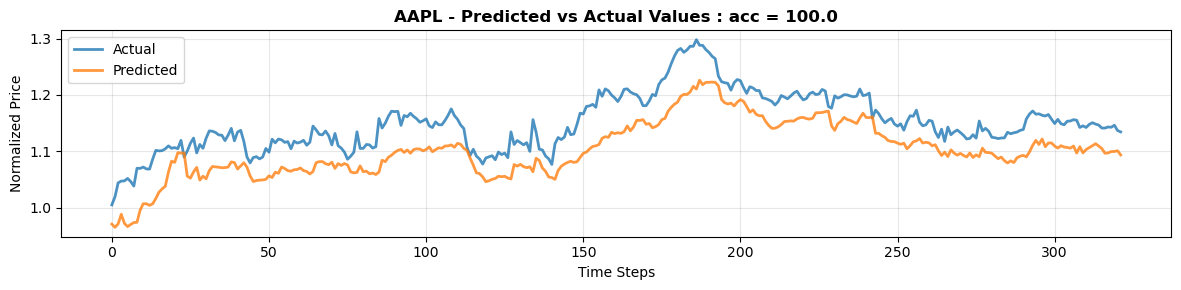

In [164]:


plot_predictions_by_asset(test_pred, test_y, sample_tickers)

In [165]:
print(test_pred.shape, test_y.shape)

(322, 1) (322, 1)


4.555627562247441
100.0


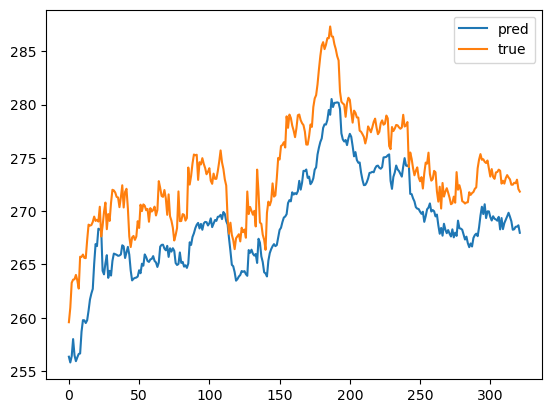

In [172]:
denorm_pred = min_max_scaling.inverse(test_pred)[:,0]
denorm_y = min_max_scaling.inverse(test_y)[:,0]
plt.plot(denorm_pred, label = 'pred')
plt.plot(denorm_y, label = 'true')
plt.legend()
plt.plot()

print(mae(denorm_pred, denorm_y))
print(directional_accuracy(denorm_pred, denorm_y))

In [167]:
# Use the existing inverse_transform method from RollingZScoreNorm class
denormalized_test_pred = norm_class.inverse_transform(test_pred, window=lookback)
denormalized_test_y = norm_class.inverse_transform(test_y, window=lookback)

print("Denormalized predictions shape:", denormalized_test_pred.shape)
print("Denormalized actuals shape:", denormalized_test_y.shape)
print("\nFirst 5 denormalized predictions:")
print(denormalized_test_pred[:5])




NameError: name 'norm_class' is not defined

In [ ]:
plot_predictions_by_asset(denormalized_test_pred, denormalized_test_y, sample_tickers)